In [1]:
from copy import deepcopy
import logging
import math
import abc
from typing import Callable, Optional, Tuple

import torch
import torch.nn as nn
from einops import reduce, repeat


logger = logging.getLogger(__name__)

def right_pad_dims_to(x, t):
	padding_dims = x.ndim - t.ndim
	if padding_dims <= 0:
		return t
	return t.view(*t.shape, *((1,) * padding_dims))


def energy_kernel(x: torch.Tensor, x_prime: torch.Tensor, beta: float, norm_dim: int = 1, **kwargs) -> torch.Tensor:
    """
    Computes the energy kernel, ||x - x'||^beta, in a generalized and stable way.

    Args:
        x (torch.Tensor): First tensor. E.g., shape (N_pairs, *feature_dims).
        x_prime (torch.Tensor): Second tensor. E.g., shape (N_pairs, *feature_dims).
        beta (float): The exponent for the energy kernel.
        norm_dim (int): The dimension(s) to sum over for the norm calculation.

    Returns:
        torch.Tensor: The result of the energy kernel calculation. Shape e.g. (N_pairs,).
    """
    if x.numel() == 0 and x_prime.numel() == 0:
        return torch.empty((0,), dtype=x.dtype, device=x.device)

    # Calculate the squared L2 norm: ||x - x'||²
    squared_norm = torch.mean((x - x_prime).square(), dim=norm_dim)

    # The exponent in the general formula: (||x - x'||²)^(β/2)
    exponent = beta / 2.0

    # Unconditionally add epsilon
    eps = torch.tensor(1e-9, device=squared_norm.device, dtype=squared_norm.dtype)
    stable_base = squared_norm + eps
    
    if isinstance(exponent, torch.Tensor):
        exponent = right_pad_dims_to(stable_base, exponent)
    
    return torch.pow(stable_base, exponent)


def rbf_kernel(x: torch.Tensor, x_prime: torch.Tensor, sigma_squared: float, norm_dim: int = 1) -> torch.Tensor:
    """
    Computes the radial basis function (RBF) kernel, optimized for efficiency.
    RBF kernel is defined as exp(-||x - x'||^2 / (2 * sigma^2)).

    Args:
        x (torch.Tensor): First tensor, e.g., shape (N_pairs, *feature_dims).
        x_prime (torch.Tensor): Second tensor, e.g., shape (N_pairs, *feature_dims).
        sigma_squared (float): The squared bandwidth parameter (sigma^2).
        norm_dim (int): Dimension(s) along which to compute the norm.

    Returns:
        torch.Tensor: RBF kernel value, e.g., shape (N_pairs,).
    """
    if x.numel() == 0 and x_prime.numel() == 0:
        return torch.empty((0,), dtype=x.dtype, device=x.device)
    
    # Calculate the squared L2 norm directly for efficiency.
    # This avoids the unnecessary sqrt(...) followed by square(...).
    squared_norm = torch.sum((x - x_prime).square(), dim=norm_dim)
    
    return torch.exp(-squared_norm / (2 * sigma_squared))


def imq_kernel(x: torch.Tensor, x_prime: torch.Tensor, c: float, norm_dim: int = 1) -> torch.Tensor:
    """
    Computes the inverse multiquadric kernel, optimized for efficiency.
    IMQ kernel is defined as (||x - x'||^2 + c^2)^(-1/2). Note the c^2 for stability.

    Args:
        x (torch.Tensor): First tensor, e.g., shape (N_pairs, *feature_dims).
        x_prime (torch.Tensor): Second tensor, e.g., shape (N_pairs, *feature_dims).
        c (float): Constant for the kernel, often interpreted as a scale parameter.
        norm_dim (int): Dimension(s) along which to compute the norm.

    Returns:
        torch.Tensor: Inverse multiquadric kernel value, e.g., shape (N_pairs,).
    """
    if x.numel() == 0 and x_prime.numel() == 0:
        return torch.empty((0,), dtype=x.dtype, device=x.device)
    
    # Calculate the squared L2 norm directly for efficiency.
    squared_norm = torch.sum((x - x_prime).square(), dim=norm_dim)
    
    # Using .rsqrt() is a fast way to compute x**(-0.5)
    return (squared_norm + c**2).rsqrt()


def exponential_kernel(x: torch.Tensor, x_prime: torch.Tensor, sigma: float, norm_dim: int = 1) -> torch.Tensor:
    """
    Computes the exponential kernel.
    Exponential kernel is defined as exp(-||x - x'|| / sigma).
    This function correctly uses the L2 norm, as required by the formula.

    Args:
        x (torch.Tensor): First tensor, e.g., shape (N_pairs, *feature_dims).
        x_prime (torch.Tensor): Second tensor, e.g., shape (N_pairs, *feature_dims).
        sigma (float): Bandwidth parameter for the kernel.
        norm_dim (int): Dimension(s) along which to compute the norm.

    Returns:
        torch.Tensor: Exponential kernel value, e.g., shape (N_pairs,).
    """
    if x.numel() == 0 and x_prime.numel() == 0:
        return torch.empty((0,), dtype=x.dtype, device=x.device)
    
    # This formula requires the true L2 norm (not the squared norm).
    norm = torch.norm(x - x_prime, p=2, dim=norm_dim)
    
    return torch.exp(-norm / sigma)


def laplace_kernel(x: torch.Tensor, x_prime: torch.Tensor, sigma: float, norm_dim: int = 1) -> torch.Tensor:
    """
    Computes the Laplace kernel, also known as the L1 kernel.
    Laplace kernel is defined as exp(-||x - x'||_1 / sigma).

    Args:
        x (torch.Tensor): First tensor, e.g., shape (N_pairs, *feature_dims).
        x_prime (torch.Tensor): Second tensor, e.g., shape (N_pairs, *feature_dims).
        sigma (float): Bandwidth parameter for the kernel.
        norm_dim (int): Dimension(s) along which to compute the norm.

    Returns:
        torch.Tensor: Laplace kernel value, e.g., shape (N_pairs,).
    """
    if x.numel() == 0 and x_prime.numel() == 0:
        return torch.empty((0,), dtype=x.dtype, device=x.device)
        
    # The Laplace kernel is standardly defined with the L1 norm (Manhattan distance).
    norm = torch.norm(x - x_prime, p=1, dim=norm_dim)
    
    return torch.exp(-norm / sigma)


class GeneralizedKernelScore(nn.Module):
    def __init__(
        self,
        kernel_function: Callable,
        lambda_val: float,
        lambda_weighting_function: Callable,
        beta_schedule: Callable,
        population_size: int,
        kernel_kwargs: dict,
        track_terms_regardless_of_lambda: bool,
        **kwargs
    ):
        super().__init__()

        self.kernel_function = kernel_function
        self.lambda_val = lambda_val
        self.lambda_weighting = lambda_weighting_function
        self.beta_schedule = beta_schedule
        self.track_terms_regardless_of_lambda = track_terms_regardless_of_lambda

        assert isinstance(population_size, int) and population_size >= 0, (
            f"population_size must be a non-negative int, got {population_size}"
        )
        self.population_size: int = population_size

        self.kernel_kwargs = kernel_kwargs
        # Check that either both or none of 'interaction_term' and 'confinement_term' are present.
        if ("interaction_term" in kernel_kwargs) != ("confinement_term" in kernel_kwargs):
            raise ValueError(
                "kernel_kwargs must contain either both 'interaction_term' and 'confinement_term' or neither."
            )
        self.interaction_kwargs = self.kernel_kwargs["interaction_term"] if "interaction_term" in self.kernel_kwargs else self.kernel_kwargs
        self.confinement_kwargs = self.kernel_kwargs["confinement_term"] if "confinement_term" in self.kernel_kwargs else self.kernel_kwargs

        self.use_scoring_rule_self_rebalancing = (
            self.kernel_kwargs["norm_based_rebalancing"]["enabled"]
            if "norm_based_rebalancing" in self.kernel_kwargs
            else False
        )
        if self.track_terms_regardless_of_lambda:
            # If we track terms regardless of lambda, we need to ensure that the population size is at least 2.
            # This is because we need pairs (j, j') where j != j'.
            assert self.population_size > 1, (
                "population_size must be at least 2 when tracking terms regardless of lambda."
            )

        assert lambda_val >= 0.0, "Lambda value must be non-negative."
        if self.lambda_val > 0:
            assert self.population_size > 1, "If lambda_val > 0, population_size must be > 1."

        # we preconstruct the pairs (j, j') where j != j'
        s_j_list = []
        s_j_prime_list = []
        for j_val in range(population_size):
            for j_prime_val in range(population_size):
                if j_val != j_prime_val:
                    s_j_list.append(j_val)
                    s_j_prime_list.append(j_prime_val)

        # These tensors will have a fixed shape (m*(m-1),) known at compile time.
        selected_j_tensor = torch.tensor(s_j_list, dtype=torch.long, requires_grad=False)
        selected_j_prime_tensor = torch.tensor(s_j_prime_list, dtype=torch.long, requires_grad=False)
        self.register_buffer("selected_j", selected_j_tensor)
        self.register_buffer("selected_j_prime", selected_j_prime_tensor)

    def get_scheduled_beta(self, t, kwargs, m):
        local_t = repeat(t, "b -> (b k)", k=m)
        beta_start = kwargs.get("beta_start", kwargs["beta"])
        beta = kwargs["beta"]
        return beta_start * self.beta_schedule(local_t) + beta * (1 - self.beta_schedule(local_t))

    def compute_rho(self, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        m: int = self.population_size  # Python constant
        n: int = x.shape[0]  # Batch size, can be symbolic

        if n == 0:  # Guard for n == 0
            return torch.empty((0,), device=x.device, dtype=x.dtype)
        if m <= 1:
            return torch.zeros((n,), device=x.device, dtype=x.dtype)

        # construct the pairs (j, j') where j != j'
        x_p1 = x[:, self.selected_j]
        y_p1 = y[:, self.selected_j_prime]
        const_num_pairs: int = m * (m - 1)
        kernel_input_shape: Tuple = (n * const_num_pairs,) + x.shape[2:]
        x_for_kernel = x_p1.reshape(kernel_input_shape)
        y_for_kernel = y_p1.reshape(kernel_input_shape)

        # apply kernel for all pairs (j, j')
        kwargs = deepcopy(self.interaction_kwargs)
        kwargs["beta"] = self.get_scheduled_beta(t, kwargs, const_num_pairs)
        rho_values_all_filtered = self.kernel_function(x_for_kernel, y_for_kernel, **kwargs)
        reduce_input_shape: Tuple = (n, const_num_pairs) + x.shape[3:]
        rho_values_per_sample_pairs = rho_values_all_filtered.reshape(reduce_input_shape)
        
        # Reduce over 'k' (pairs) AND '...' (any remaining kernel_output_feature_dims)
        mean_rho_for_each_sample = reduce(rho_values_per_sample_pairs, "b k ... -> b", "mean")
        return mean_rho_for_each_sample

    def compute_rho_diagonal(self, x: torch.Tensor, y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        m: int = self.population_size  # Python constant
        n: int = x.shape[0]  # Batch size, can be symbolic

        if n == 0:  # Guard for n == 0
            return torch.empty((0,), device=x.device, dtype=x.dtype)
        if m == 0:
            return torch.zeros((n,), device=x.device, dtype=x.dtype)

        # prepare input for kernel
        kernel_input_shape: Tuple = (n * m,) + x.shape[2:]
        x_reshaped = x.reshape(kernel_input_shape)
        y_reshaped = y.reshape(kernel_input_shape)

        # apply kernel            
        kwargs = deepcopy(self.confinement_kwargs)
        kwargs["beta"] = self.get_scheduled_beta(t, kwargs, m)
        rho_values = self.kernel_function(x_reshaped, y_reshaped, **kwargs)

        # reshape to match the expected output shape
        reduce_input_shape: Tuple = (n, m) + x.shape[3:]
        rho_values_2d_plus = rho_values.reshape(reduce_input_shape)

        # Reduce over 'm' (population samples) AND '...' (any remaining kernel_output_feature_dims)
        mean_rho_for_each_sample = reduce(rho_values_2d_plus, "b m ... -> b", "mean")
        return mean_rho_for_each_sample

    def __call__(
        self, x: torch.Tensor, y: torch.Tensor, t: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor], Optional[torch.Tensor]]:
        # e_rho_xp_y is the confinement term
        confinement_term = self.compute_rho_diagonal(x, y, t)
        score = -confinement_term
        
        
        interaction_term = None
        interaction_term_mult_by_lambda = None
        if self.lambda_val > 0 or self.track_terms_regardless_of_lambda:
            # we track all the values regardless of lambda if the flag is active
            interaction_term = self.compute_rho(x, x, t)
            weighted_lambda = self.lambda_val * self.lambda_weighting(t)
            interaction_term_mult_by_lambda = (weighted_lambda / 2.0) * interaction_term

            # but we add the interaction term only if lambda_val > 0
            if self.lambda_val > 0:
                # score is already negative, so this adds a positive term
                # equivalent to score = 0.5 * lambda * interaction_term - confinement_term
                score = interaction_term_mult_by_lambda + score

        return score, confinement_term, interaction_term, interaction_term_mult_by_lambda


## helpers


def log(t, eps=1e-20):
    return torch.log(t.clamp(min=eps))


def logsnr_schedule_cosine(t, logsnr_min=-15, logsnr_max=15):
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -2 * log(torch.tan(t_min + t * (t_max - t_min)))


## lambda schedules


class LambdaSchedule(abc.ABC):
    """
    Abstract base class for lambda schedules.
    """
    
    def __init__(self, num_timesteps: int):
        self.num_timesteps = num_timesteps
        
    def normalized_t(self, t: torch.Tensor) -> int:
        # normalize t to [0, 1]
        return t / (self.num_timesteps - 1)

    @abc.abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the lambda value at time t.
        """
        pass

class CosineScheduleNormalized(LambdaSchedule):
    def __init__(self, num_timesteps: int, logsnr_min=-15, logsnr_max=15):
        super().__init__(num_timesteps)
        self.logsnr_min = logsnr_min
        self.logsnr_max = logsnr_max

        t_min = math.atan(math.exp(-0.5 * logsnr_max))
        t_max = math.atan(math.exp(-0.5 * logsnr_min))
        self.t_min = t_min
        self.t_max = t_max

    def __call__(self, t):
        t = self.normalized_t(t)
        return -(
            -2 * log(torch.tan(self.t_min + t * (self.t_max - self.t_min))) / (self.logsnr_max - self.logsnr_min) - 0.5
        )


class SigmoidScheduleNormalized(LambdaSchedule):
    """Kingma et al. (2021) SNR loss weighting."""

    def __init__(self, num_timesteps: int, b=0):
        super().__init__(num_timesteps)
        self.b = b

    def __call__(self, t):
        t = self.normalized_t(t)
        logsnr = logsnr_schedule_cosine(t)
        weight = (1 + (self.b - logsnr).exp()) ** -1

        return 1 - weight


def SigmoidScheduleShiftedNormalized(num_timesteps: int, b=-2):
    return SigmoidScheduleNormalized(num_timesteps=num_timesteps, b=b)


class LinearScheduleNormalized(LambdaSchedule):
    """Linear schedule normalized to [0, 1]."""

    def __call__(self, t):
        t = self.normalized_t(t)
        return t
    
class ConstantScheduleNormalized(LambdaSchedule):
    """Constant schedule normalized to [0, 1]."""

    def __call__(self, t):
        return torch.ones_like(t)
        
class StepScheduleNormalized(LambdaSchedule):
    """Step schedule normalized to [0, 1]."""
    
    def __init__(self, num_timesteps: int, step=0.7):
        super().__init__(num_timesteps)
        self.step = step

    def __call__(self, t):
        t = self.normalized_t(t)
        return (t >= self.step).to(t.dtype)  # Convert boolean to float (0.0 or 1.0)
        
class DynamicalRegimesScheduleNormalized(LambdaSchedule):
    """Dynamical regimes schedule normalized to [0, 1]."""

    def __init__(self, num_timesteps: int, interpolation: LambdaSchedule, regimes=(0.6420, 0.9115)):
        super().__init__(num_timesteps)
        self.regimes = regimes
        self.interpolation = interpolation

    def __call__(self, t):
        t = self.normalized_t(t)
        # 1. Define the boolean masks for each of the three regimes.
        # These masks will have the same shape as `t`.
        is_before_regime = t < self.regimes[0]
        is_after_regime = t > self.regimes[1]
        
        # 2. Calculate the value for the interpolation regime.
        # This calculation is performed on all elements, but we will use `torch.where`
        # to select only the ones that fall within the interpolation regime.
        t_local = (t - self.regimes[0]) / (self.regimes[1] - self.regimes[0])
        interpolation_result = self.interpolation(t_local * (self.num_timesteps - 1))

        # 3. Use nested `torch.where` to apply the conditions element-wise.
        # This is the tensor-based equivalent of the original `if/elif/else` block.
        
        # First, handle the 'elif/else' logic:
        # If an element is in the "after" regime, use 1.0; otherwise, use its interpolation result.
        after_or_interp_result = torch.where(
            is_after_regime, 
            torch.ones_like(t), # Value if True
            interpolation_result           # Value if False
        )

        # Now, handle the 'if' logic:
        # If an element is in the "before" regime, use 0.0; otherwise, use the result from the step above.
        final_result = torch.where(
            is_before_regime,
            torch.zeros_like(t), # Value if True
            after_or_interp_result          # Value if False
        )

        return final_result

def DynamicalRegimesScheduleNormalizedWithLinearInterpolation(num_timesteps: int):
    """
    Factory function to create a DynamicalRegimesScheduleNormalized with linear interpolation.
    
    Args:
        num_timesteps (int): Number of timesteps for the schedule.
        
    Returns:
        DynamicalRegimesScheduleNormalized: An instance of DynamicalRegimesScheduleNormalized with linear interpolation.
    """
    return DynamicalRegimesScheduleNormalized(
        num_timesteps=num_timesteps,
        interpolation=LinearScheduleNormalized(num_timesteps=num_timesteps),
        regimes=(0.6420, 0.9115)
    )
    
def DynamicalRegimesScheduleNormalizedWithCosineInterpolation(num_timesteps: int):
    """
    Factory function to create a DynamicalRegimesScheduleNormalized with cosine interpolation.
    
    Args:
        num_timesteps (int): Number of timesteps for the schedule.
        
    Returns:
        DynamicalRegimesScheduleNormalized: An instance of DynamicalRegimesScheduleNormalized with cosine interpolation.
    """
    return DynamicalRegimesScheduleNormalized(
        num_timesteps=num_timesteps,
        interpolation=CosineScheduleNormalized(num_timesteps=num_timesteps),
        regimes=(0.6420, 0.9115)
    )
    
def DynamicalRegimesScheduleNormalizedWithSigmoidInterpolation(num_timesteps: int):
    """
    Factory function to create a DynamicalRegimesScheduleNormalized with sigmoid interpolation.
    
    Args:
        num_timesteps (int): Number of timesteps for the schedule.
        
    Returns:
        DynamicalRegimesScheduleNormalized: An instance of DynamicalRegimesScheduleNormalized with sigmoid interpolation.
    """
    return DynamicalRegimesScheduleNormalized(
        num_timesteps=num_timesteps,
        interpolation=SigmoidScheduleNormalized(num_timesteps=num_timesteps),
        regimes=(0.6420, 0.9115)
    )
    
def DynamicalRegimesScheduleNormalizedWithSigmoidShiftedInterpolation(num_timesteps: int):
    """
    Factory function to create a DynamicalRegimesScheduleNormalized with shifted sigmoid interpolation.
    
    Args:
        num_timesteps (int): Number of timesteps for the schedule.
        
    Returns:
        DynamicalRegimesScheduleNormalized: An instance of DynamicalRegimesScheduleNormalized with shifted sigmoid interpolation.
    """
    return DynamicalRegimesScheduleNormalized(
        num_timesteps=num_timesteps,
        interpolation=SigmoidScheduleShiftedNormalized(num_timesteps=num_timesteps, b=2),
        regimes=(0.6420, 0.9115)
    )
    
def DynamicalRegimesScheduleNormalizedWithStepInterpolation(num_timesteps: int):
    """
    Factory function to create a DynamicalRegimesScheduleNormalized with step interpolation.
    
    Args:
        num_timesteps (int): Number of timesteps for the schedule.
        
    Returns:
        DynamicalRegimesScheduleNormalized: An instance of DynamicalRegimesScheduleNormalized with step interpolation.
    """
    return DynamicalRegimesScheduleNormalized(
        num_timesteps=num_timesteps,
        interpolation=StepScheduleNormalized(num_timesteps=num_timesteps, step=0),
        regimes=(0.6420, 0.9115)
    )


def create_generalized_kernel_score(
    *,
    kernel_function: str,
    lambda_val: float,
    lambda_weighting_function: str,
    beta_schedule: str,
    population_size: int,
    kernel_kwargs: dict,
    track_terms_regardless_of_lambda: bool,
    num_timesteps: int,
    **kwargs
) -> GeneralizedKernelScore:
    """
    Factory function to create a GeneralizedKernelScore instance based on the specified kernel function and lambda weighting.

    Args:
        kernel_function (str): Name of the kernel function to use.
        lambda_val (float): Lambda value for the scoring rule.
        lambda_weighting (str): Name of the lambda weighting function to use.
        track_terms_regardless_of_lambda (bool): Whether to track terms regardless of lambda.
        population_size (int): Size of the population for the scoring rule.
        kernel_kwargs (dict): Additional keyword arguments for the scoring rule.

    Returns:
        GeneralizedKernelScore: An instance of GeneralizedKernelScore configured with the specified parameters.
    """

    kernel_function_map = {
        "energy": energy_kernel,
        "imq": imq_kernel,
        "rbf": rbf_kernel,
        "exponential": exponential_kernel,
        "laplace": laplace_kernel,
    }
    lambda_weighting_map = {
        "constant": ConstantScheduleNormalized(num_timesteps=num_timesteps),
        "linear": LinearScheduleNormalized(num_timesteps=num_timesteps),
        "cosine": CosineScheduleNormalized(num_timesteps=num_timesteps),
        "sigmoid": SigmoidScheduleNormalized(num_timesteps=num_timesteps),
        "sigmoid_shifted": SigmoidScheduleShiftedNormalized(num_timesteps=num_timesteps),
        "step": StepScheduleNormalized(num_timesteps=num_timesteps),
        "dynamical_linear": DynamicalRegimesScheduleNormalizedWithLinearInterpolation(num_timesteps=num_timesteps),
        "dynamical_cosine": DynamicalRegimesScheduleNormalizedWithCosineInterpolation(num_timesteps=num_timesteps),
        "dynamical_sigmoid": DynamicalRegimesScheduleNormalizedWithSigmoidInterpolation(num_timesteps=num_timesteps),
        "dynamical_sigmoid_shifted": DynamicalRegimesScheduleNormalizedWithSigmoidShiftedInterpolation(num_timesteps=num_timesteps),
        "dynamical_step": DynamicalRegimesScheduleNormalizedWithStepInterpolation(num_timesteps=num_timesteps),
    }

    if kernel_function not in kernel_function_map:
        raise ValueError(
            f"Unknown kernel function: {kernel_function}. Available options: {list(kernel_function_map.keys())}"
        )
    if lambda_weighting_function not in lambda_weighting_map:
        raise ValueError(
            f"Unknown lambda weighting function: {lambda_weighting_function}. Available options: {list(lambda_weighting_map.keys())}"
        )
    if beta_schedule not in lambda_weighting_map:
        raise ValueError(
            f"Unknown beta schedule: {beta_schedule}. Available options: {list(lambda_weighting_map.keys())}"
        )

    kernel_fn = kernel_function_map[kernel_function]
    lambda_weighting_fn = lambda_weighting_map[lambda_weighting_function]
    beta_schedule_fn = lambda_weighting_map[beta_schedule]

    return GeneralizedKernelScore(
        kernel_function=kernel_fn,
        lambda_val=lambda_val,
        lambda_weighting_function=lambda_weighting_fn,
        beta_schedule=beta_schedule_fn,
        population_size=population_size,
        kernel_kwargs=kernel_kwargs,
        track_terms_regardless_of_lambda=track_terms_regardless_of_lambda,
        **kwargs
    )


/tmp/ipykernel_2054276/3497749035.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


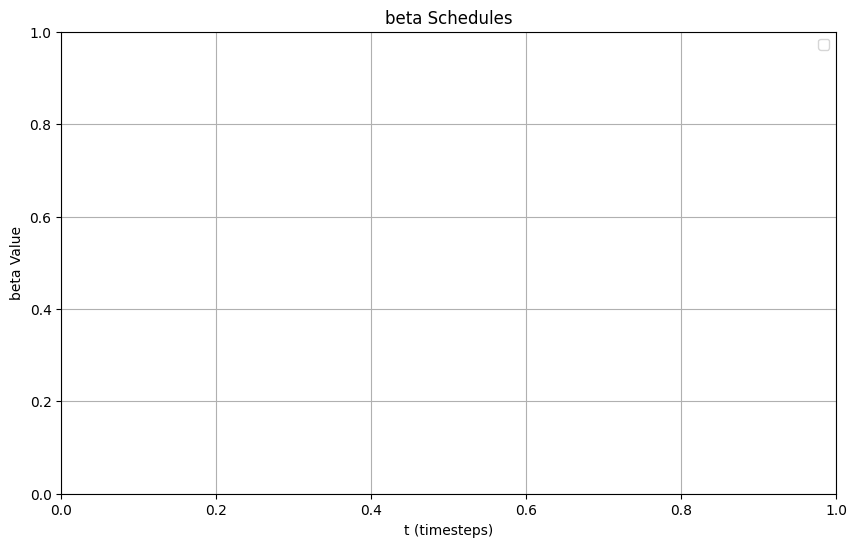

In [15]:
# plot t on the x axis and the schedules on the y axis
def plot_beta_schedules(num_timesteps: int, schedules: dict):
    import matplotlib.pyplot as plt

    t = torch.arange(num_timesteps, dtype=torch.float32)
    plt.figure(figsize=(10, 6))

    beta_start = 1
    beta = 2
    lambda_value = 1
    for name, schedule in schedules.items():
        beta_values = beta_start * schedule(t) + beta * (1 - schedule(t))
        lambda_values = lambda_value * schedule(t)
        plt.plot(t.numpy(), beta_values.numpy(), label=name)
        plt.plot(t.numpy(), lambda_values.numpy(), label=name)

    plt.title("beta Schedules")
    plt.xlabel("t (timesteps)")
    plt.ylabel("beta Value")
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()  # Close the plot to avoid displaying it in interactive environments

instantiated_schedules = {
    # "constant": ConstantScheduleNormalized(num_timesteps=4000),
    # "linear": LinearScheduleNormalized(num_timesteps=4000),
    # "cosine": CosineScheduleNormalized(num_timesteps=4000),
    # "sigmoid": SigmoidScheduleNormalized(num_timesteps=4000),
    # "sigmoid_shifted": SigmoidScheduleShiftedNormalized(num_timesteps=4000),
    # "step": StepScheduleNormalized(num_timesteps=4000),
    # "dynamical_linear": DynamicalRegimesScheduleNormalizedWithLinearInterpolation(num_timesteps=4000),
    # "dynamical_cosine": DynamicalRegimesScheduleNormalizedWithCosineInterpolation(num_timesteps=4000),
    # "dynamical_sigmoid": DynamicalRegimesScheduleNormalizedWithSigmoidInterpolation(num_timesteps=4000),
    # "dynamical_sigmoid_shifted": DynamicalRegimesScheduleNormalizedWithSigmoidShiftedInterpolation(num_timesteps=4000),
    # "dynamical_step": DynamicalRegimesScheduleNormalizedWithStepInterpolation(num_timesteps=4000)
}

plot_beta_schedules(
    num_timesteps=4000,
    schedules=instantiated_schedules
)

In [4]:
import numpy as np
import math

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

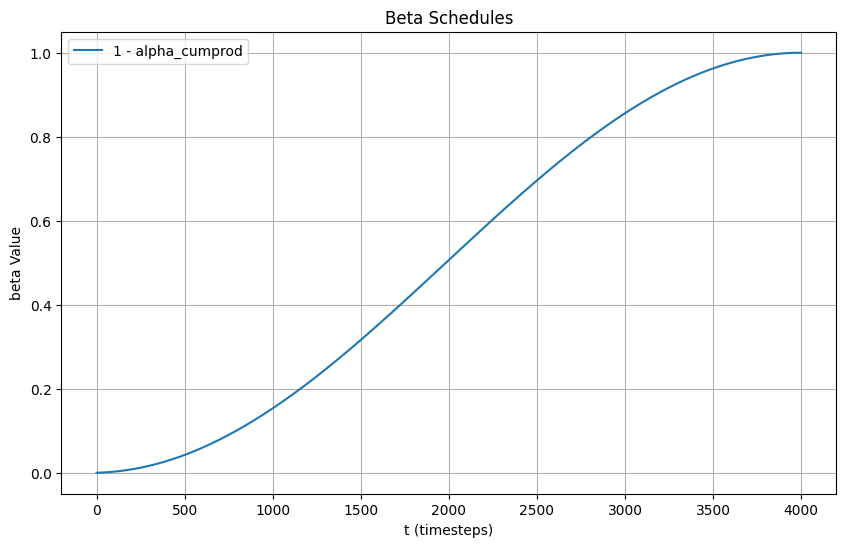

In [11]:
import matplotlib.pyplot as plt


num_timesteps = 4000

cosine_betas = get_named_beta_schedule("cosine", num_timesteps)
alphas = 1.0 - cosine_betas
alphas_cumprod = np.cumprod(alphas, axis=0)

schedule_s = SigmoidScheduleNormalized(num_timesteps=4000)
schedule_c = CosineScheduleNormalized(num_timesteps=4000)
t = torch.arange(num_timesteps, dtype=torch.float32)
aaa = schedule_s(t)
bbb = schedule_c(t)

logsnr = np.clip(np.log(alphas_cumprod / (1 - alphas_cumprod)), -15, 15)

b = 0
sig = torch.nn.functional.sigmoid(b - torch.tensor(logsnr))

mysig = 1 - (1 + (b - torch.tensor(logsnr)).exp()) ** -1


plt.figure(figsize=(10, 6))
# plt.plot(0.5 - (logsnr / 30), label="logsnr")
# plt.plot(bbb, label="cosine")
# plt.plot(aaa, label="sigmoid")
# plt.plot(bbb, label="cosine")
plt.plot(1 - alphas_cumprod, label="1 - alpha_cumprod")
# plt.plot(sig, label="sig")
# plt.plot(mysig, label="mysig")
plt.title("Beta Schedules")
plt.xlabel("t (timesteps)")
plt.ylabel("beta Value")
plt.legend()
plt.grid()
plt.show()
plt.close()